# Análisis Exploratorio

En esta sección, realizaremos un análisis inicial del conjunto de datos **UrbanSound8K**. Este análisis nos permitirá comprender la estructura y el contenido del banco de datos descargado. Antes de continuar, es importante asegurarnos de que se haya ejecutado correctamente el script **setup.sh** y que la carpeta ***UrbanSound8K*** esté ubicada dentro de la carpeta `data`.

El conjunto de datos contiene información sobre archivos de audio clasificados en diferentes categorías de sonidos urbanos. A continuación, exploraremos las características principales del dataframe, incluyendo las columnas disponibles, el número de registros, los tipos de datos y las estadísticas descriptivas.


In [1]:
# Importing necessary libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical computations
import matplotlib.pyplot as plt  # For plotting and visualizationa
import librosa  # For audio processing
from IPython.display import Audio  # For audio playback in Jupyter
import glob  # For file path pattern matching
from sklearn.preprocessing import LabelEncoder  # For encoding labels
import tensorflow as tf  # For deep learning models
import os  # For operating system interactions

# Configure matplotlib to display plots inline in the notebook
%matplotlib inline

2025-05-10 18:36:49.730239: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-10 18:36:49.776484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746923809.789372  124446 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746923809.793082  124446 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746923809.803955  124446 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Check GPU availability
# This code aims to verify if there are devices available for processing,
# specifically GPUs, as this model is large and the data to process (audio) is also large.
# Using a GPU can significantly accelerate the training of the model.
print("Available devices:")
print(tf.config.list_physical_devices())

Available devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Load the data
# Define the base path where the audio files and metadata are located
FILES_PATH = "./data/UrbanSound8K"  # Path to the audio files
ESC_50_PATH = "./data/ESC-50-master"  # Path to the ESC-50 dataset

# Read the CSV file containing the metadata of the UrbanSound8K dataset
# This file includes information such as file name, sound class, duration, etc.
dataframe_audios = pd.read_csv(
    f"{FILES_PATH}/metadata/UrbanSound8K.csv"
)  # UrbanSound8K provides this file upon downloading the dataset

dataframe_esc_50 = pd.read_csv(
    f"{ESC_50_PATH}/meta/esc50.csv"
)  # ESC-50 provides this file upon downloading the dataset

# Display the first few rows of the DataFrame to inspect its content
dataframe_audios.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [4]:
dataframe_esc_50.head()


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


### Combinando los DataFrames y manejando IDs y nombres distintos

En esta sección, se realizará la combinación de los DataFrames `dataframe_audios` y `extra_dataframe`. Además, se gestionarán los conflictos relacionados con los IDs de clase (`classID`) y los nombres de las clases (`class`) para garantizar que no existan duplicados y que los datos estén correctamente alineados. Esto incluye ajustar los valores de `classID` en caso de que haya solapamientos y unificar los nombres de las clases para evitar inconsistencias.

In [5]:
extra_dataframe = dataframe_esc_50.copy()

extra_dataframe.rename(
    columns={
        "filename": "slice_file_name",
        "src_file": "fsID",
        "category": "class",
        "esc10": "salience",
        "target": "classID",
    },
    inplace=True,
)
extra_dataframe["start"] = 0
extra_dataframe["end"] = np.nan
extra_dataframe.drop(columns=["take"], inplace=True)
extra_dataframe.head()

,slice_file_name,fold,classID,class,salience,fsID,start,end
0,1-100032-A-0.wav,1,0,dog,True,100032,0,NaN
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,0,NaN
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,0,NaN
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,0,NaN
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,0,NaN


In [6]:
# Add a new column "audio_path" to the dataframe
# This column contains the full file path for each audio file in the dataset.
# The path is constructed using the base path (FILES_PATH), the fold number, and the slice file name.
dataframe_audios["audio_path"] = dataframe_audios.apply(
    lambda row: os.path.join(
        FILES_PATH, "audio", f"fold{row['fold']}", row["slice_file_name"]
    ),
    axis=1,
)

extra_dataframe["audio_path"] = extra_dataframe.apply(
    lambda row: os.path.join(ESC_50_PATH, "audio", row["slice_file_name"]), axis=1
)

# Display the first few rows of the updated dataframe to verify the new column
dataframe_audios.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,audio_path
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,./data/UrbanSound8K/audio/fold5/100032-3-0-0.wav
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,./data/UrbanSound8K/audio/fold5/100263-2-0-117...
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,./data/UrbanSound8K/audio/fold5/100263-2-0-121...
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,./data/UrbanSound8K/audio/fold5/100263-2-0-126...
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,./data/UrbanSound8K/audio/fold5/100263-2-0-137...


In [7]:
extra_dataframe.head()

,slice_file_name,fold,classID,class,salience,fsID,start,end,audio_path
0,1-100032-A-0.wav,1,0,dog,True,100032,0,NaN,./data/ESC-50-master/audio/1-100032-A-0.wav
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,0,NaN,./data/ESC-50-master/audio/1-100038-A-14.wav
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,0,NaN,./data/ESC-50-master/audio/1-100210-A-36.wav
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,0,NaN,./data/ESC-50-master/audio/1-100210-B-36.wav
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,0,NaN,./data/ESC-50-master/audio/1-101296-A-19.wav


In [8]:
# merging the dataframes, but to handle the classID column, we need to ensure that the class names are consistent we will increase the extra_dataframe classID by the max classID of the dataframe_audios
# This is done to avoid any conflicts in class IDs when merging the two dataframes.
# The classID of the extra_dataframe is adjusted by adding the maximum classID from the dataframe_audios.
# This ensures that the class IDs from both datasets are unique and do not overlap.
max_class_id = dataframe_audios["classID"].max()
extra_dataframe["classID"] = extra_dataframe["classID"] + max_class_id + 1

# merging the two dataframes
# The two dataframes are concatenated into a single dataframe called "dataframe".
# This combined dataframe will be used for further processing and model training.
dataframe_audios = pd.concat([dataframe_audios, extra_dataframe], ignore_index=True)
# Display the first few rows of the merged dataframe to verify the result
dataframe_audios

,slice_file_name,fsID,start,end,salience,fold,classID,class,audio_path
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,./data/UrbanSound8K/audio/fold5/100032-3-0-0.wav
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,./data/UrbanSound8K/audio/fold5/100263-2-0-117...
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,./data/UrbanSound8K/audio/fold5/100263-2-0-121...
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,./data/UrbanSound8K/audio/fold5/100263-2-0-126...
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,./data/UrbanSound8K/audio/fold5/100263-2-0-137...
...,...,...,...,...,...,...,...,...,...
10727,5-263831-B-6.wav,263831,0.0,NaN,0,5,16,hen,./data/ESC-50-master/audio/5-263831-B-6.wav
10728,5-263902-A-36.wav,263902,0.0,NaN,0,5,46,vacuum_cleaner,./data/ESC-50-master/audio/5-263902-A-36.wav
10729,5-51149-A-25.wav,51149,0.0,NaN,0,5,35,footsteps,./data/ESC-50-master/audio/5-51149-A-25.wav
10730,5-61635-A-8.wav,61635,0.0,NaN,0,5,18,sheep,./data/ESC-50-master/audio/5-61635-A-8.wav


## Analisis del dataframe

In [9]:
# Display basic information about the dataframe
# The `info()` method provides a concise summary of the dataframe, including the number of entries,
# column names, non-null counts, and data types. This helps to understand the structure of the dataset.
dataframe_audios.info()

# Generate descriptive statistics for the dataframe
# The `describe()` method computes summary statistics for numerical columns, such as count, mean,
# standard deviation, min, max, and percentiles. This is useful for understanding the distribution
# and range of the data.
dataframe_audios.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10732 entries, 0 to 10731
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  10732 non-null  object 
 1   fsID             10732 non-null  int64  
 2   start            10732 non-null  float64
 3   end              8732 non-null   float64
 4   salience         10732 non-null  int64  
 5   fold             10732 non-null  int64  
 6   classID          10732 non-null  int64  
 7   class            10732 non-null  object 
 8   audio_path       10732 non-null  object 
dtypes: float64(2), int64(4), object(3)
memory usage: 754.7+ KB


,fsID,start,end,salience,fold,classID
count,10732.000000,10732.000000,8732.000000,10732.000000,10732.000000,10732.000000
mean,120070.635762,31.443506,42.253312,1.133246,4.941297,10.166325
std,59929.652088,68.681336,74.369669,0.643198,2.798202,13.463460
min,137.000000,0.000000,0.105962,0.000000,1.000000,0.000000
25%,72015.000000,0.500000,6.839398,1.000000,3.000000,3.000000
50%,123688.000000,6.000000,14.000000,1.000000,5.000000,5.000000
75%,170566.500000,26.495901,38.866979,2.000000,7.000000,9.000000
max,264453.000000,600.125356,604.125356,2.000000,10.000000,59.000000


In [10]:
# Display descriptive statistics for the dataframe
# The `describe()` method provides a summary of statistics for both numerical and categorical columns.
# By using `include="all"`, it includes all columns, regardless of their data type.
# This helps to understand the distribution, central tendency, and spread of the data,
# as well as unique values and frequency for categorical columns.
dataframe_audios.describe(include="all")

,slice_file_name,fsID,start,end,salience,fold,classID,class,audio_path
count,10732,10732.000000,10732.000000,8732.000000,10732.000000,10732.000000,10732.000000,10732,10732
unique,10732,NaN,NaN,NaN,NaN,NaN,NaN,58,10732
top,5-9032-A-0.wav,NaN,NaN,NaN,NaN,NaN,NaN,dog_bark,./data/ESC-50-master/audio/5-9032-A-0.wav
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,1000,1
mean,NaN,120070.635762,31.443506,42.253312,1.133246,4.941297,10.166325,NaN,NaN
std,NaN,59929.652088,68.681336,74.369669,0.643198,2.798202,13.463460,NaN,NaN
min,NaN,137.000000,0.000000,0.105962,0.000000,1.000000,0.000000,NaN,NaN
25%,NaN,72015.000000,0.500000,6.839398,1.000000,3.000000,3.000000,NaN,NaN
50%,NaN,123688.000000,6.000000,14.000000,1.000000,5.000000,5.000000,NaN,NaN
75%,NaN,170566.500000,26.495901,38.866979,2.000000,7.000000,9.000000,NaN,NaN


In [11]:
# Display unique classes and their counts
# The `unique()` method is used to list all unique categories in the "class" column.
# This provides an overview of the different sound classes present in the dataset.
print("Categorías únicas:", dataframe_audios["class"].unique())

# The `value_counts()` method counts the occurrences of each category in the "class" column.
# This helps to understand the distribution of samples across different sound classes.
print("Conteo por clase:\n", dataframe_audios["class"].value_counts())

Categorías únicas: ['dog_bark' 'children_playing' 'car_horn' 'air_conditioner' 'street_music'
 'gun_shot' 'siren' 'engine_idling' 'jackhammer' 'drilling' 'dog'
 'chirping_birds' 'vacuum_cleaner' 'thunderstorm' 'door_wood_knock'
 'can_opening' 'crow' 'clapping' 'fireworks' 'chainsaw' 'airplane'
 'mouse_click' 'pouring_water' 'train' 'sheep' 'water_drops'
 'church_bells' 'clock_alarm' 'keyboard_typing' 'wind' 'footsteps' 'frog'
 'cow' 'brushing_teeth' 'crackling_fire' 'helicopter' 'drinking_sipping'
 'rain' 'insects' 'laughing' 'hen' 'engine' 'breathing' 'crying_baby'
 'hand_saw' 'coughing' 'glass_breaking' 'snoring' 'toilet_flush' 'pig'
 'washing_machine' 'clock_tick' 'sneezing' 'rooster' 'sea_waves' 'cat'
 'door_wood_creaks' 'crickets']
Conteo por clase:
 class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
jackhammer          1000
engine_idling       1000
drilling            1000
siren                969
car_horn             469
gun

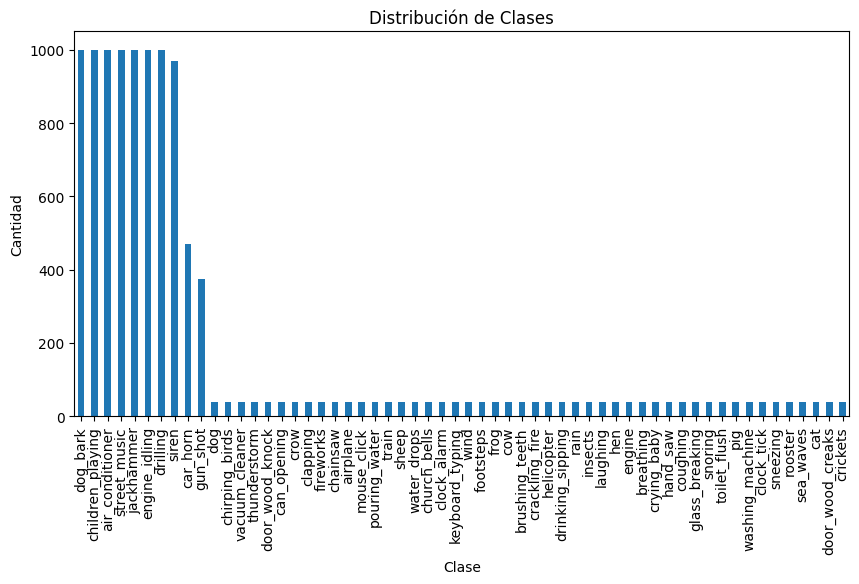

In [12]:
# Visualize the distribution of classes in the dataset
# The `value_counts()` method counts the occurrences of each unique value in the "class" column.
# This provides an overview of how many samples belong to each sound class.
# The `plot()` method is used to create a bar chart to visualize this distribution.

dataframe_audios["class"].value_counts().plot(kind="bar", figsize=(10, 5))

# Add a title and labels to the plot for better understanding
plt.title("Distribución de Clases")  # Title of the plot
plt.ylabel("Cantidad")  # Label for the y-axis
plt.xlabel("Clase")  # Label for the x-axis

# Display the plot
plt.show()

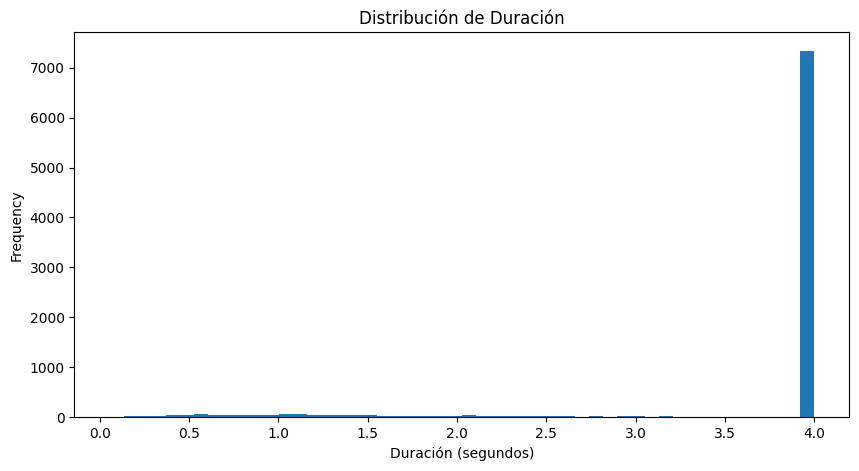

In [13]:
# Calculate the duration of each audio clip
# The "duration" column is computed as the difference between the "end" and "start" columns,
# which represent the start and end times of each audio clip in seconds.
dataframe_audios["duration"] = dataframe_audios["end"] - dataframe_audios["start"]

# Plot the distribution of audio durations
# A histogram is created to visualize the distribution of audio clip durations.
# The x-axis represents the duration in seconds, and the y-axis represents the frequency of clips.
dataframe_audios["duration"].plot(kind="hist", bins=50, figsize=(10, 5))

# Add a title and labels to the plot for better understanding
plt.title("Distribución de Duración")  # Title of the plot
plt.xlabel("Duración (segundos)")  # Label for the x-axis

# Display the plot
plt.show()

### Probando la carga y visualización de un audio

En esta sección, cargaremos un archivo de audio del conjunto de datos y lo visualizaremos. Para ello, utilizaremos las herramientas de procesamiento de audio disponibles en la biblioteca `librosa`. Además, acotaremos la visualización del audio según los tiempos de inicio y fin especificados en el dataframe `dataframe_audios`. Esto nos permitirá analizar de manera más detallada las características del audio seleccionado.

In [14]:
# Load and play an audio file to ensure the audio data is correctly loaded and audible.
# This step is crucial for verifying the integrity of the audio files in the dataset.

# Select an audio file (e.g., the first row)
audio_file_path = dataframe_audios["audio_path"].iloc[0]  # Adjust the path if necessary
audio_data, sample_rate = librosa.load(audio_file_path, sr=None)  # Load audio

# Play the audio
Audio(data=audio_data, rate=sample_rate)

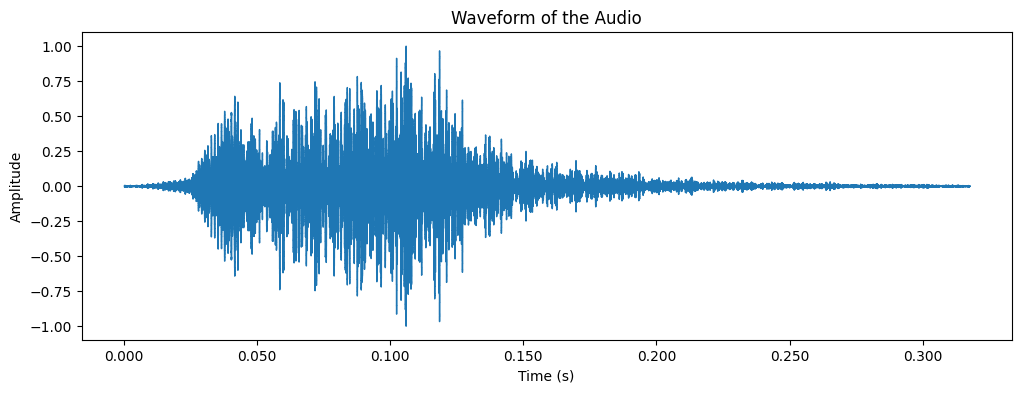

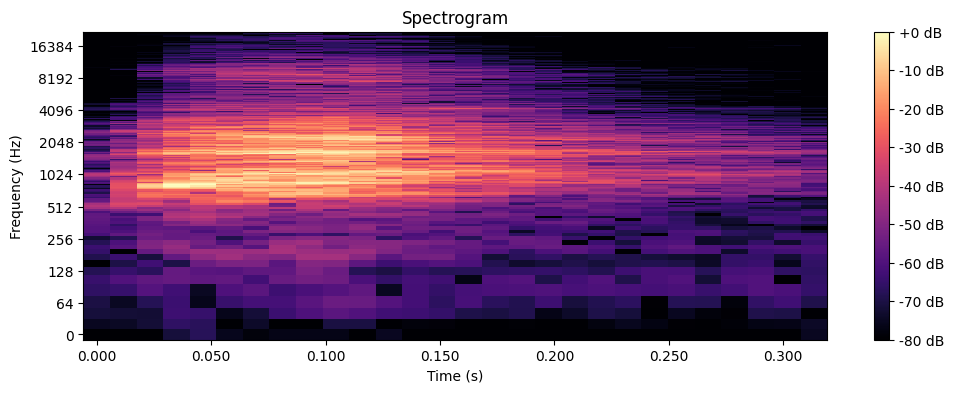

In [15]:
# Visualize the waveform and spectrogram of the audio file
# This step helps us understand the time-domain and frequency-domain characteristics of the audio data.

# Plot the waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(audio_data, sr=sample_rate)
plt.title("Waveform of the Audio")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Plot the spectrogram
# The spectrogram provides a visual representation of the frequency content of the audio over time.
spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data)), ref=np.max)
plt.figure(figsize=(12, 4))
librosa.display.specshow(spectrogram, sr=sample_rate, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()

# Preparacion de los datos


In [16]:
# Encode class labels into numerical format
# This step is necessary to prepare the data for machine learning models, which require numerical inputs.
label_encoder = LabelEncoder()
dataframe_audios["encoded_label"] = label_encoder.fit_transform(
    dataframe_audios["class"]
)  # Add a new column 'encoded_label' with numerical IDs for each class
number_of_classes = len(
    dataframe_audios["class"].unique()
)  # Calculate the total number of unique sound classes
number_of_classes

58

In [17]:
# Split the dataset into training and testing sets in a stratified manner
# This ensures that the distribution of classes is preserved in both sets, which is crucial for balanced training and evaluation.

from sklearn.model_selection import train_test_split

# Features: paths to audio files
audio_file_paths = dataframe_audios["audio_path"]

# Target: encoded class labels
encoded_labels = dataframe_audios["encoded_label"]

# Perform the stratified split
train_audio_paths, test_audio_paths, train_labels, test_labels = train_test_split(
    audio_file_paths,
    encoded_labels,
    test_size=0.3,
    random_state=42,
    stratify=encoded_labels,
)


## Extraer las características de los audios

En este módulo, nos enfocaremos en la extracción de características relevantes de los archivos de audio. Específicamente, utilizaremos los coeficientes cepstrales de frecuencia de Mel (MFCC) para representar cada archivo de audio como un tensor numérico. Los MFCC son ampliamente utilizados en el procesamiento de señales de audio, ya que capturan información importante sobre el contenido espectral del sonido, lo que los hace ideales para tareas de clasificación y reconocimiento de audio.

El objetivo es implementar funciones que permitan calcular los MFCC de cada archivo de audio y garantizar que todos los tensores tengan una longitud fija, aplicando padding o recorte según sea necesario. Esto asegurará que los datos estén en un formato consistente para ser utilizados en modelos de aprendizaje profundo.

### Normalizar los MFCCs

En este paso, normalizamos las características MFCC para garantizar que todos los valores estén en una escala similar, lo que ayuda a mejorar el rendimiento y la estabilidad del modelo durante el entrenamiento.

### Agregar características delta (opcional)

Las características delta representan la tasa de cambio de los MFCCs a lo largo del tiempo. Agregar estas características puede proporcionar información temporal adicional, lo que podría mejorar la capacidad del modelo para clasificar señales de audio.

In [18]:
def extract_mfcc(audio_file_path, num_mfcc=13, max_padding_length=174, sr=22050):
    """
    Extracts MFCCs with delta and delta-delta features from an audio file.
    Returns an array of shape (39, max_padding_length) for each file.
    """
    # 1. Load audio
    audio_signal, sample_rate = librosa.load(audio_file_path, sr=sr)

    # 2. Extract base MFCCs
    mfcc_features = librosa.feature.mfcc(
        y=audio_signal, sr=sample_rate, n_mfcc=num_mfcc, fmax=sample_rate / 2
    )

    # 3. Normalize
    mfcc_features = librosa.util.normalize(mfcc_features)

    # 4. Adjust length FIRST (padding or truncation)
    if mfcc_features.shape[1] < max_padding_length:
        mfcc_features = np.pad(
            mfcc_features,
            ((0, 0), (0, max_padding_length - mfcc_features.shape[1])),
            mode="constant",
        )
    else:
        mfcc_features = mfcc_features[:, :max_padding_length]

    # 5. NOW compute deltas (safe because all have max_padding_length frames)
    delta_mfcc = librosa.feature.delta(mfcc_features)
    delta2_mfcc = librosa.feature.delta(mfcc_features, order=2)

    # Combine (13 MFCC + 13 delta + 13 delta-delta = 39)
    combined_features = np.concatenate((mfcc_features, delta_mfcc, delta2_mfcc))

    return combined_features

# Modelo CNN

En este módulo, implementaremos una red neuronal convolucional (CNN) para procesar los coeficientes cepstrales de frecuencia de Mel (MFCCs) extraídos de los archivos de audio. Las CNN son especialmente efectivas para tareas de clasificación de datos estructurados espacialmente, como imágenes o, en este caso, representaciones espectrales de audio.

La arquitectura de la red incluye capas convolucionales para extraer características relevantes, capas de normalización para estabilizar el entrenamiento, y capas densas con regularización para evitar el sobreajuste. Finalmente, la red utiliza una capa de salida con activación softmax para clasificar los audios en las diferentes categorías de sonidos urbanos.


In [19]:
from tensorflow.keras import layers, models, regularizers

# Configuration
# Define the input shape for the model. It includes 39 features (13 MFCC + 13 delta + 13 delta-delta),
# a fixed padding length of 174, and a single channel.
input_shape = (39, 174, 1)

# Define the number of output classes based on the dataset.
num_classes = number_of_classes

# Model Architecture
# We are building a Convolutional Neural Network (CNN) for audio classification.
# The architecture includes convolutional layers for feature extraction,
# pooling layers for dimensionality reduction, and dense layers for classification.
model = models.Sequential(
    [
        # Input layer
        layers.Input(shape=input_shape),
        # Convolutional Block 1
        # Extract features using 32 filters of size (3, 3), followed by batch normalization,
        # max pooling to reduce spatial dimensions, and dropout for regularization.
        layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        # Convolutional Block 2
        # Use 64 filters of size (3, 3) for deeper feature extraction, followed by batch normalization,
        # max pooling, and dropout for regularization.
        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        # Convolutional Block 3
        # Use 128 filters of size (3, 3) for even deeper feature extraction, followed by batch normalization,
        # max pooling, and dropout for regularization.
        layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        # Dense Layers
        # Flatten the feature maps into a 1D vector, followed by a dense layer with 256 units
        # and L2 regularization to prevent overfitting. Batch normalization and dropout are applied.
        layers.Flatten(),
        layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        # Output Layer
        # Use a dense layer with `num_classes` units and softmax activation for multi-class classification.
        layers.Dense(num_classes, activation="softmax"),
    ]
)

# Compilation
# Compile the model with the Adam optimizer, sparse categorical crossentropy loss (suitable for integer labels),
# and accuracy as the evaluation metric.
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Summary
# Display the model architecture and the number of trainable parameters.
model.summary()

I0000 00:00:1746923830.941955  124446 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6166 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 39, 174, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 39, 174, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 87, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 87, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 19, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 19, 87, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 43, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 9, 43, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 43, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 9, 43, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 21, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 21, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10752)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,752,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 58)             │        14,906 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,862,266 (10.92 MB)

 Trainable params: 2,861,306 (10.92 MB)

 Non-trainable params: 960 (3.75 KB)

**ENTRENAMIENTO DEL MODELO**

En esta etapa, procederemos a entrenar el modelo de clasificación de audio utilizando los coeficientes cepstrales de frecuencia de Mel (MFCC) previamente extraídos. Este proceso puede tomar un tiempo considerable dependiendo de la capacidad de procesamiento de la GPU disponible y del tamaño del conjunto de datos. Asegúrate de contar con los recursos necesarios antes de iniciar el entrenamiento.

In [20]:
# Feature extraction
X_train = np.array([extract_mfcc(path) for path in train_audio_paths])
X_test = np.array([extract_mfcc(path) for path in test_audio_paths])

# Add channel dimension
X_train = X_train[..., np.newaxis]  # Shape: (samples, 39, 174, 1)
X_test = X_test[..., np.newaxis]

# Convert labels to numpy arrays
y_train = np.array(train_labels)
y_test = np.array(test_labels)


/mnt/data/files/url/url-notas/docs/0-RES/tecnologias-emergentes/proyecto final/venv/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/mnt/data/files/url/url-notas/docs/0-RES/tecnologias-emergentes/proyecto final/venv/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/mnt/data/files/url/url-notas/docs/0-RES/tecnologias-emergentes/proyecto final/venv/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [22]:
# Callbacks for training
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
]

# Training
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=70,  # after training the previous model, i saw it established a plateau at 70 epochs
    batch_size=32,
    callbacks=callbacks,
)

Epoch 1/70


I0000 00:00:1746923929.103025  124550 service.cc:152] XLA service 0x798508009170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746923929.103046  124550 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-05-10 18:38:49.146114: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746923929.372070  124550 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-05-10 18:38:50.043048: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2707', 80 bytes spill stores, 80 bytes spill loads



 22/235 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0603 - loss: 5.2707

I0000 00:00:1746923933.113054  124550 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


230/235 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2468 - loss: 3.9126

2025-05-10 18:38:55.620517: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2707', 56 bytes spill stores, 56 bytes spill loads



235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.2490 - loss: 3.8975 - val_accuracy: 0.0932 - val_loss: 13.1183 - learning_rate: 0.0010
Epoch 2/70
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4691 - loss: 2.4930 - val_accuracy: 0.0913 - val_loss: 5.9293 - learning_rate: 0.0010
Epoch 3/70
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5341 - loss: 2.1119 - val_accuracy: 0.2102 - val_loss: 5.2495 - learning_rate: 0.0010
Epoch 4/70
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5944 - loss: 1.8254 - val_accuracy: 0.3444 - val_loss: 3.1373 - learning_rate: 0.0010
Epoch 5/70
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6375 - loss: 1.7054 - val_accuracy: 0.3602 - val_loss: 3.4996 - learning_rate: 0.0010
Epoch 6/70
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6536 - loss: 1.6903 - val_accuracy: 0.2292 - val_loss: 4.2341 - learning_rate: 0.0010
Epoch 7/70
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6882 - loss: 1.5442 - val_accu

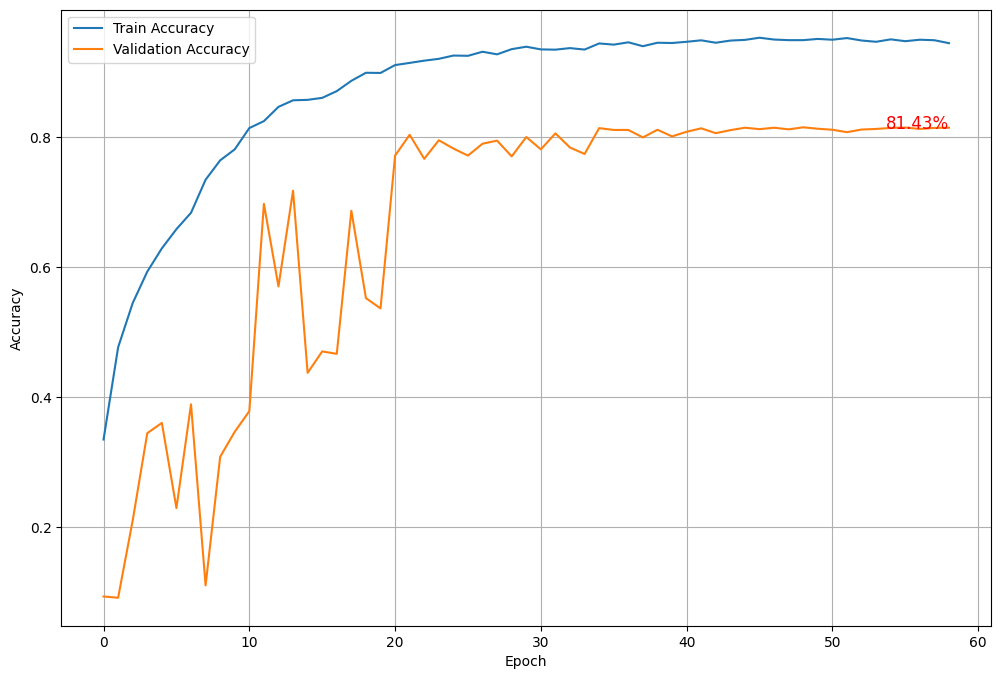

In [23]:
# curva de aprendizaje
plt.figure(figsize=(12, 8))  # Aumentar el tamaño de la figura
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")

# Agregar texto con el accuracy final
final_val_accuracy = (
    history.history["val_accuracy"][-1] * 100
)  # Último valor de val_accuracy
plt.text(
    len(history.history["val_accuracy"]) - 1,  # Última época
    history.history["val_accuracy"][-10],  # Valor de val_accuracy
    f"{final_val_accuracy:.2f}%",  # Texto con el porcentaje
    fontsize=12,
    color="red",
    ha="right",
)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)  # Añadir una cuadrícula para mayor precisión
plt.show()

In [24]:
# Evaluate the model on the test dataset
# Why we do this:
# - To measure the model's performance on unseen data.
# - To calculate the test accuracy and loss for evaluation purposes.
test_loss, test_accuracy = model.evaluate(
    X_test,  # Changed from X_test_mfcc_features to X_test
    y_test,  # Changed from test_labels to y_test (numpy array version)
)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8013 - loss: 0.9589
Test Accuracy: 81.49%


In [25]:
# Generate a confusion matrix to analyze model predictions
# Why we do this:
# - To visualize the performance of the model in terms of correctly and incorrectly classified samples.
# - To identify patterns of misclassification for further improvements.
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
predicted_labels = np.argmax(
    model.predict(X_test),  # Changed from X_test_mfcc_features to X_test
    axis=1,
)

# Generate confusion matrix
confusion_matrix_result = confusion_matrix(
    y_test, predicted_labels
)  # Changed from test_labels to y_test

101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


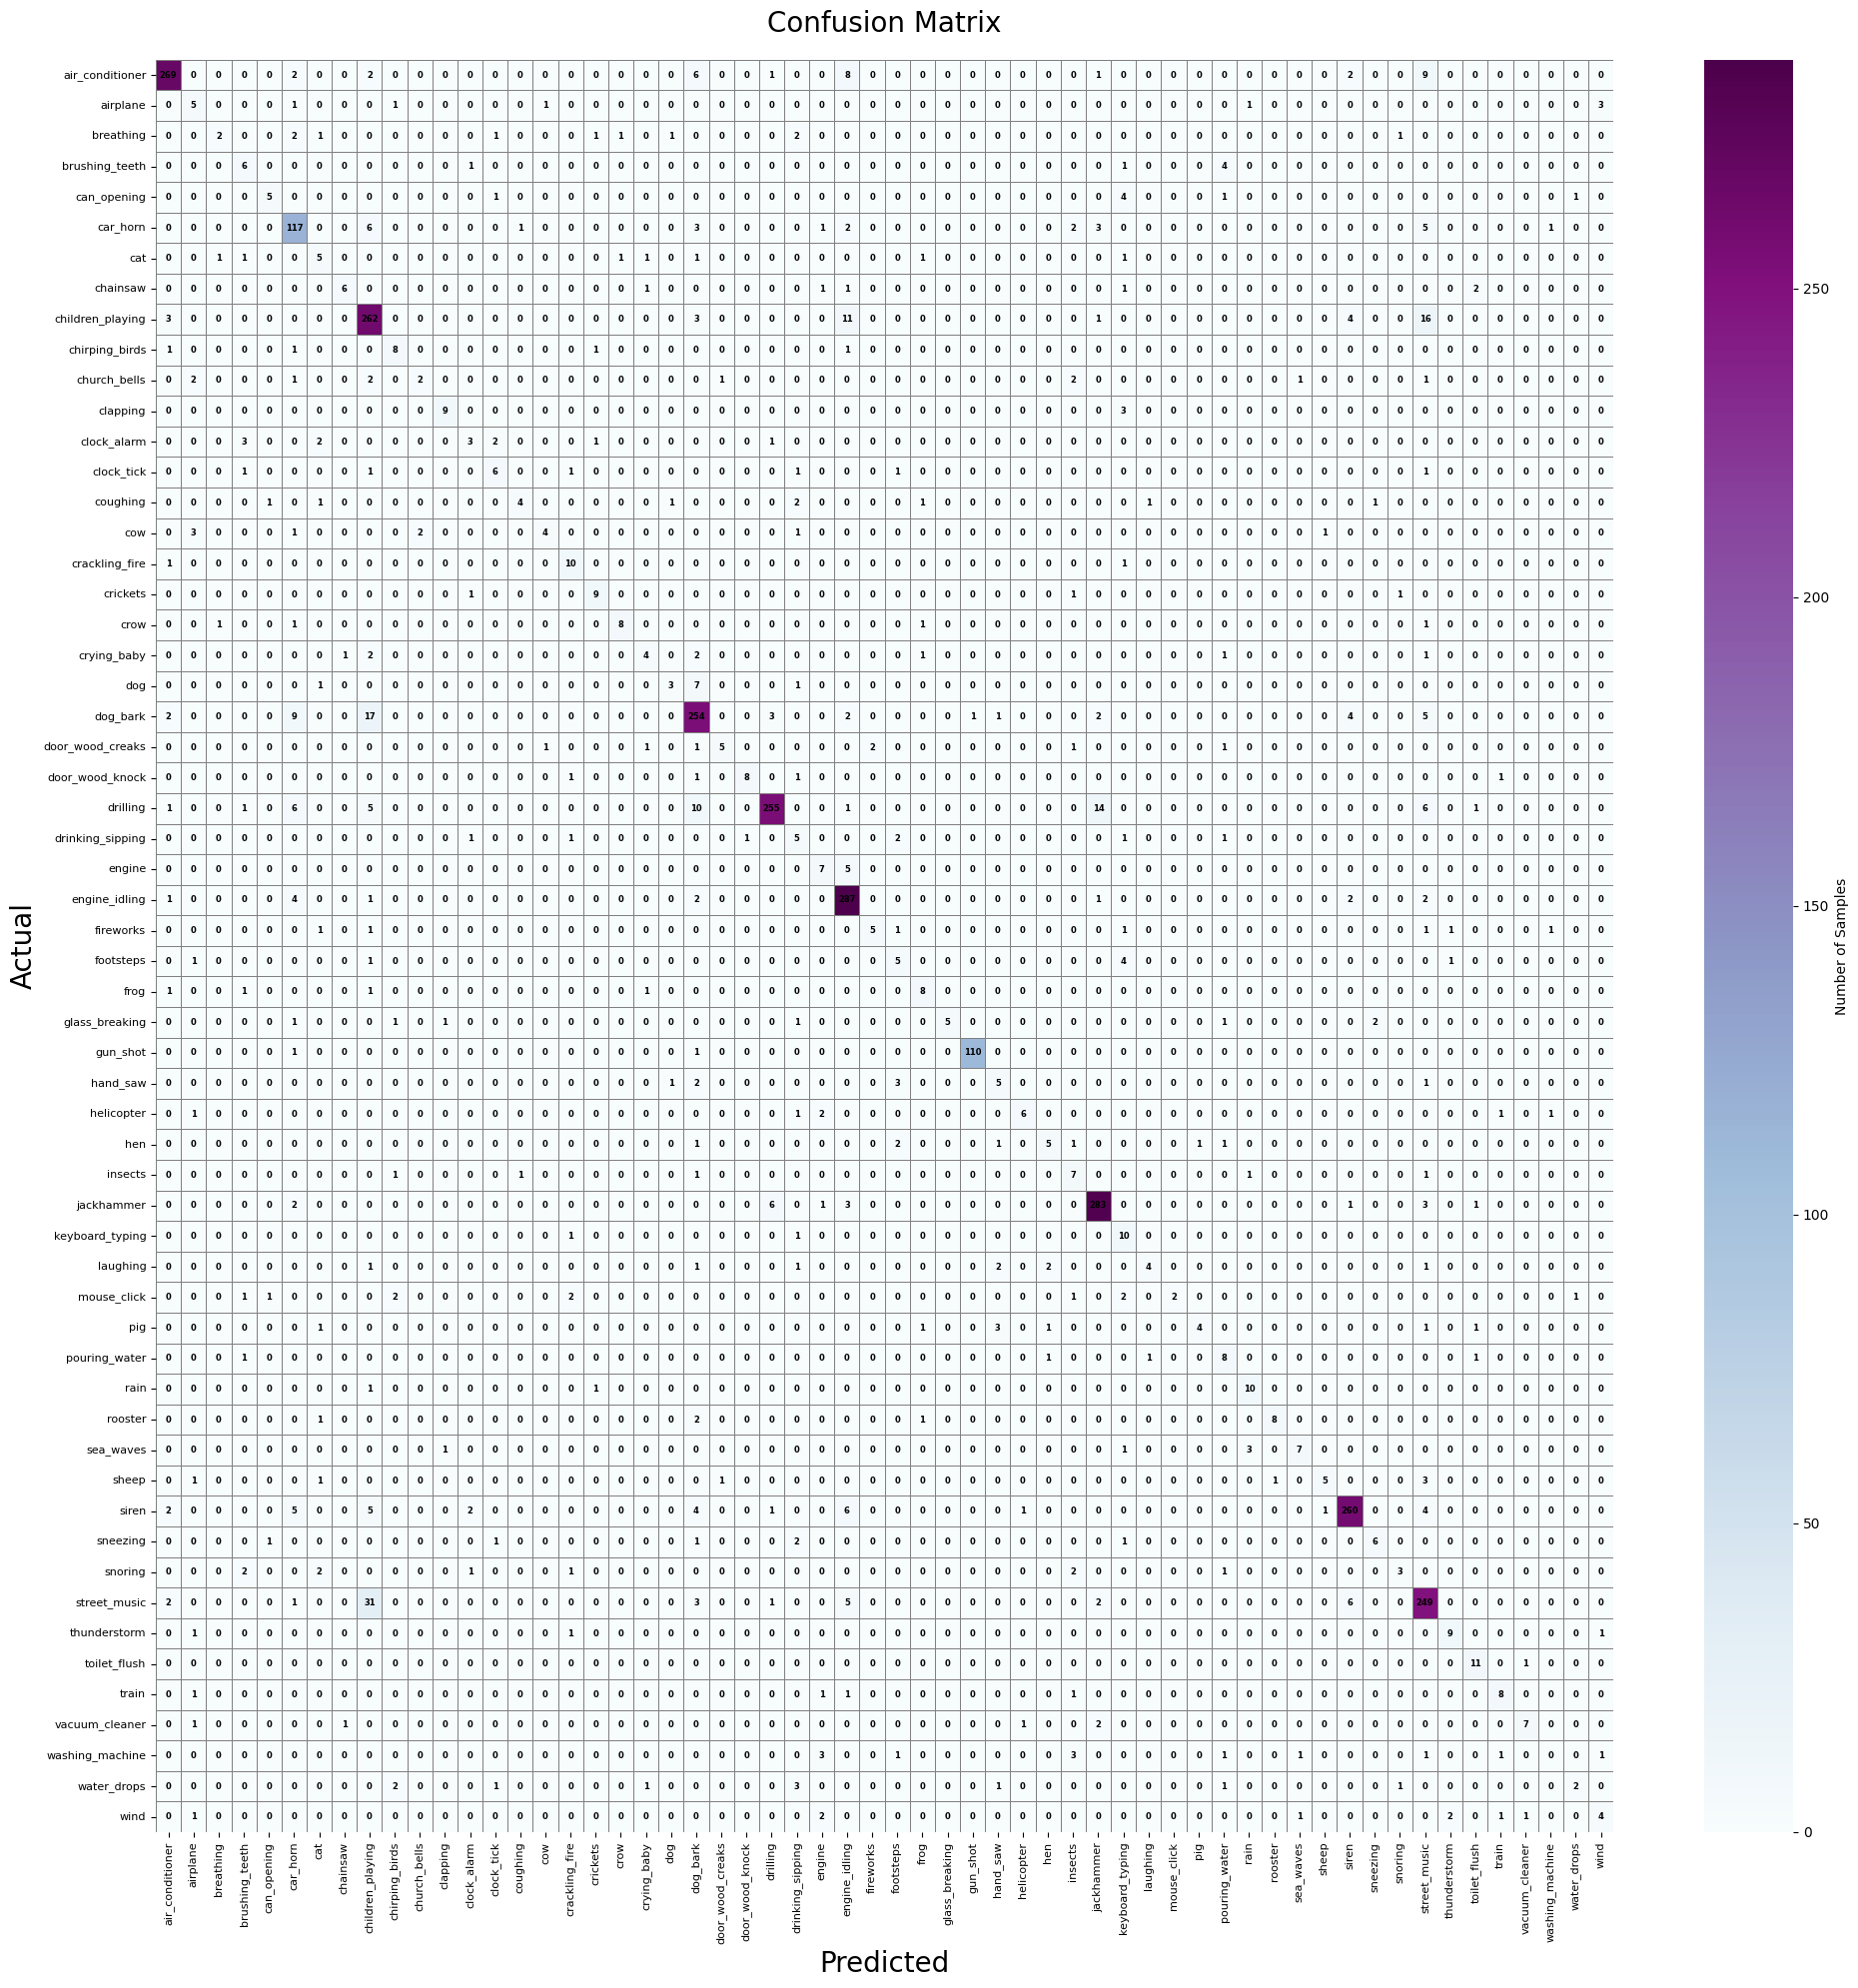

In [26]:
# Crear el heatmap
plt.figure(figsize=(20, 20))  # Tamaño más grande para que entren bien las etiquetas

# Ensure class names are extracted from the label encoder
class_names = label_encoder.classes_

# Create the heatmap
ax = sns.heatmap(
    confusion_matrix_result,
    annot=True,
    fmt="d",
    cmap="BuPu",  # Cambiado a "viridis"
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=0.5,
    linecolor="grey",
    cbar_kws={"label": "Number of Samples"},
    annot_kws={"size": 6, "color": "black", "weight": "bold"},  # Cambiado a negro
)

# Ajustar los textos
ax.set_title("Confusion Matrix", fontsize=20, pad=20)
ax.set_xlabel("Predicted", fontsize=20)
ax.set_ylabel("Actual", fontsize=20)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)

# Fondo del eje
ax.set_facecolor("black")

# Layout para evitar recortes
plt.tight_layout()
plt.show()


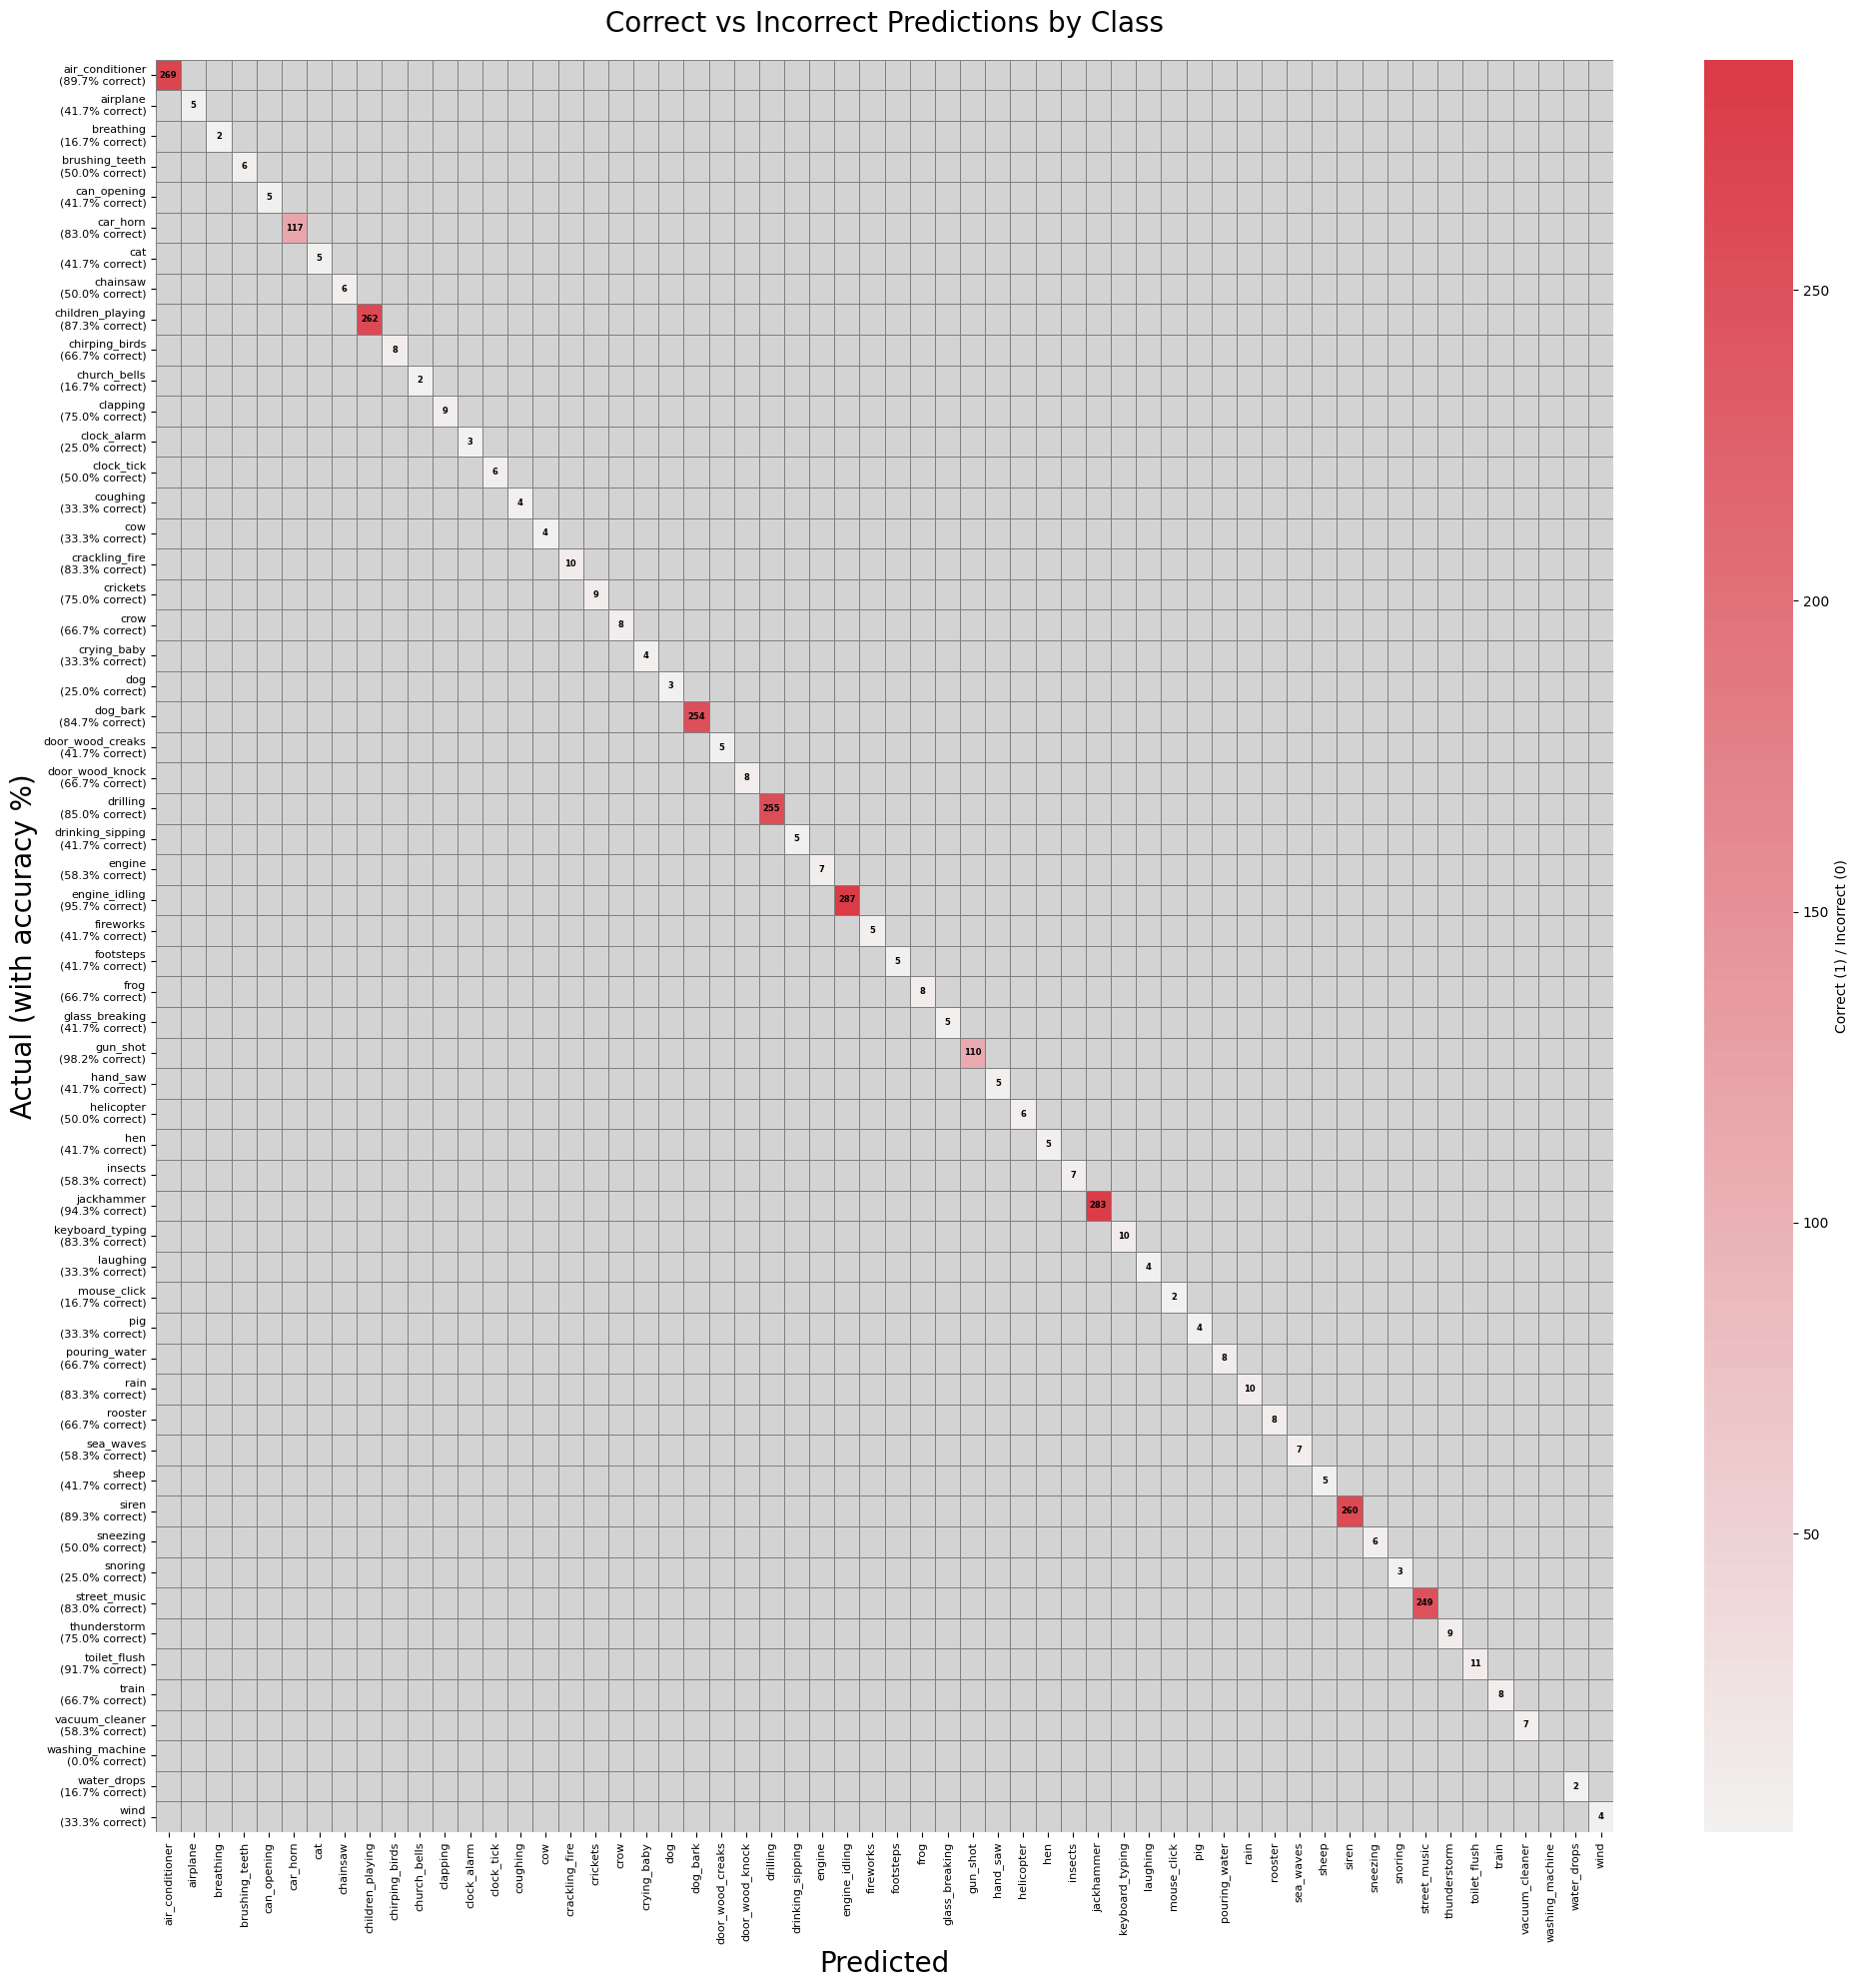

In [27]:
import numpy as np

# Crear matriz binaria de correctos/incorrectos
correct_matrix = np.zeros_like(confusion_matrix_result)
np.fill_diagonal(correct_matrix, 1)  # Marcamos la diagonal como correctos (1)
binary_matrix = (
    confusion_matrix_result * correct_matrix
)  # Solo quedan los valores de la diagonal

# Matriz de incorrectos (todo menos la diagonal)
incorrect_matrix = confusion_matrix_result - binary_matrix

# Porcentaje de correctos por clase
total_samples = confusion_matrix_result.sum(axis=1)
correct_percentage = np.diag(confusion_matrix_result) / total_samples * 100

# Crear el heatmap
plt.figure(figsize=(20, 20))

# Paleta de colores: verde para correcto, rojo para incorrecto
cmap = sns.diverging_palette(120, 10, as_cmap=True)

ax = sns.heatmap(
    binary_matrix,  # Mostramos solo la matriz binaria
    annot=confusion_matrix_result,  # Mostramos los valores originales como anotación
    fmt="d",
    cmap=cmap,
    center=0.5,
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=0.5,
    linecolor="grey",
    cbar_kws={"label": "Correct (1) / Incorrect (0)"},
    annot_kws={"size": 6, "color": "black", "weight": "bold"},
    mask=(binary_matrix == 0),  # Enmascaramos los incorrectos para mostrarlos en blanco
)

# Añadir porcentaje de acierto en el eje y
yticklabels = [
    f"{name}\n({perc:.1f}% correct)"
    for name, perc in zip(class_names, correct_percentage)
]
ax.set_yticklabels(yticklabels, rotation=0, fontsize=8)

# Ajustar los textos
ax.set_title("Correct vs Incorrect Predictions by Class", fontsize=20, pad=20)
ax.set_xlabel("Predicted", fontsize=20)
ax.set_ylabel("Actual (with accuracy %)", fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)

# Fondo del eje
ax.set_facecolor("lightgray")

# Layout para evitar recortes
plt.tight_layout()
plt.show()

: Guardar y cargar el modelo entrenado

En esta sección, se explica cómo guardar el modelo entrenado en un formato recomendado por Keras y cómo cargarlo posteriormente para realizar predicciones o continuar con el entrenamiento. Guardar el modelo permite reutilizarlo sin necesidad de volver a entrenarlo, lo que ahorra tiempo y recursos computacionales. Además, se asegura la persistencia del modelo para futuros análisis o implementaciones.

In [28]:
# Save the trained audio classification model
# Why we do this:
# - To persist the trained model for future use without retraining.
# - To ensure reproducibility and save computational resources.
model.save("./model/audio_classification_model.keras")

# Load the saved audio classification model
# Why we do this:
# - To reuse the trained model for predictions or further training.
# - To validate that the saved model can be successfully restored.
loaded_audio_classification_model = tf.keras.models.load_model(
    "./model/audio_classification_model.keras"
)


In [29]:
def predict_audio_class(audio_file_path):
    """
    Why we do this:
    - To predict the class of a given audio file using the trained CNN model.
    - To convert the MFCC features of the audio into a format compatible with the model.
    - To decode the predicted class index back into the original class label.
    """
    # Extract MFCC features and reshape for model input
    mfcc_features = extract_mfcc(audio_file_path)[np.newaxis, ..., np.newaxis]

    # Predict the class probabilities
    predictions = model.predict(mfcc_features)

    # Get the class index with the highest probability
    predicted_class_index = np.argmax(predictions)

    # Decode the class index to the original class label
    predicted_class_label = label_encoder.inverse_transform([predicted_class_index])[0]

    return predicted_class_label

In [30]:
import random
import json


def predict_and_save_results(
    test_audio_paths,
    test_labels,
    label_encoder,
    num_samples=14,
    output_file="predictions.json",
):
    """
    Randomly selects audio files, makes predictions, and saves results to JSON.

    Args:
        test_audio_paths: DataFrame/Series of test audio paths
        test_labels: Corresponding test labels
        label_encoder: LabelEncoder instance
        num_samples: Number of samples to test
        output_file: Path to save JSON results
    """
    # Randomly select audio files
    random_indices = random.sample(range(len(test_audio_paths)), num_samples)
    selected_audio_files = test_audio_paths.iloc[random_indices]
    selected_labels = test_labels.iloc[random_indices]

    results = []

    for i, audio_file in enumerate(selected_audio_files):
        actual_label = label_encoder.inverse_transform([selected_labels.iloc[i]])[0]
        predicted_label = predict_audio_class(audio_file)

        # Create result dictionary
        result = {
            "audio_path": str(audio_file),
            "actual_label": actual_label,
            "predicted_label": predicted_label,
            "correct": actual_label == predicted_label,
        }
        results.append(result)

        # Print to console
        print(f"Audio File: {audio_file}")
        print(f"Actual Label: {actual_label}")
        print(f"Predicted Label: {predicted_label}")
        print("-" * 50)

    # Save to JSON
    with open(output_file, "w") as f:
        json.dump(results, f, indent=4)

    print(f"\nSaved prediction results to {output_file}")
    return results


# Usage
prediction_results = predict_and_save_results(
    test_audio_paths,
    test_labels,
    label_encoder,
    num_samples=14,
    output_file="./model/audio_predictions.json",
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
Audio File: ./data/ESC-50-master/audio/3-118059-A-18.wav
Actual Label: toilet_flush
Predicted Label: toilet_flush
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Audio File: ./data/UrbanSound8K/audio/fold2/18581-3-0-5.wav
Actual Label: dog_bark
Predicted Label: air_conditioner
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Audio File: ./data/UrbanSound8K/audio/fold8/180134-4-1-3.wav
Actual Label: drilling
Predicted Label: drilling
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Audio File: ./data/UrbanSound8K/audio/fold6/132162-9-1-58.wav
Actual Label: street_music
Predicted Label: street_music
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Audio File: ./data/UrbanSound8K/audio/fold5/180128-4-7-3.wav
Actual Label: drilling
Predicted Label: drilling
------------------------------------